# 1. Fitting of time-dependant beta (cosine) to real data

To fit the data, a data sample from the years 2009-2012 of Influenza recorded by the WHO for France was used. The data can be found here:

https://app.powerbi.com/view?r=eyJrIjoiNjViM2Y4NjktMjJmMC00Y2NjLWFmOWQtODQ0NjZkNWM1YzNmIiwidCI6ImY2MTBjMGI3LWJkMjQtNGIzOS04MTBiLTNkYzI4MGFmYjU5MCIsImMiOjh9

- **Seasonal Transmission ($\beta(t)$):** The average transmission rate $\beta_0$ is modulated by a cosine function to account for yearly seasonality, driving the timing and width of the peaks.
    $$\beta(t) = \beta_0 \cdot \left(1 + A_{\beta} \cos(\omega t + \phi_{\beta})\right)$$

- **Reporting ($\rho(t)$):** The reporting fraction is also modeled seasonally. This is essential for accurately fitting, as surveillance efficiency often changes with the season or (weekly) case volume.

- **Waning Immunity ($\xi$):** The rate $\xi$ controls the flow of individuals from the Recovered ($R$) compartment back to the Susceptible ($S$) compartment, for modeling long-term, recurrent waves.

- **Solver:** A robust **RK4** numerical integrator is used to solve the ODEs.
- Optimization minimizes the **Log-Scaled Sum of Squared Errors (SSE)**.
    $$\text{SSE} = \sum_{t} \left[ \log(\text{Modeled Cases}_t + 1) - \log(\text{Observed Cases}_t + 1) \right]^2$$
    
Disclaimer: running the global optimization can take a while

Loading data from 7bohjaiU(2).csv...
Loaded 232 weeks of data. Max cases: 1358.
Starting SEIRS Global Optimization (RK4 Solver)...
differential_evolution step 1: f(x)= 431.102
differential_evolution step 2: f(x)= 382.313
differential_evolution step 3: f(x)= 382.313
differential_evolution step 4: f(x)= 328.249
differential_evolution step 5: f(x)= 288.903
differential_evolution step 6: f(x)= 223.8
differential_evolution step 7: f(x)= 223.8
differential_evolution step 8: f(x)= 223.8
differential_evolution step 9: f(x)= 218.555
differential_evolution step 10: f(x)= 186.455
differential_evolution step 11: f(x)= 186.455
differential_evolution step 12: f(x)= 186.455
differential_evolution step 13: f(x)= 186.455
differential_evolution step 14: f(x)= 186.455
differential_evolution step 15: f(x)= 186.455
differential_evolution step 16: f(x)= 186.455
differential_evolution step 17: f(x)= 186.455
differential_evolution step 18: f(x)= 186.455
differential_evolution step 19: f(x)= 178.853
differenti

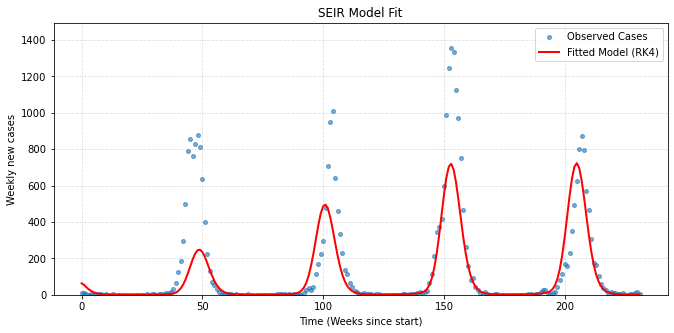

In [25]:
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

#start by defining rk4 solver fucntion
def rk4_solve(func, y0, t_eval, args=(), dt=0.5):
    #Solves ODE using RK4
    y = np.array(y0)
    results = [y]
    current_t = t_eval[0]
    
    for next_t in t_eval[1:]:
        
        while current_t < next_t:
            step = next_t - current_t if (current_t + dt > next_t) else dt
            h = step #step size RK4

            # RK4 Steps
            k1 = np.array(func(y, current_t, *args)) * h
            k2 = np.array(func(y + k1 * 0.5, current_t + h * 0.5, *args)) * h
            k3 = np.array(func(y + k2 * 0.5, current_t + h * 0.5, *args)) * h
            k4 = np.array(func(y + k3, current_t + h, *args)) * h
            
            # Weighted average update
            y = y + (k1 + 2*k2 + 2*k3 + k4) / 6.0
            current_t += step
            
        results.append(y)
        
    return np.array(results)

#definition of SEIR model
def seirs_model_derivs_weekly(y, t, beta0, amplitude, phase, gamma, sigma, xi, N):
    # Rates per week.
    S, E, I, R = y
    T_w = 365.25 / 7.0 #conversion to weekly
    
    # seasonal beta(t)
    beta_t = beta0 * (1 + amplitude * np.cos((2 * np.pi / T_w * t) + phase))
    beta_t = max(0.0, beta_t) 
    
    # SEIR Equations
    dSdt = -beta_t * S * I / N + xi * R
    dEdt = beta_t * S * I / N - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I - xi * R
    
    return [dSdt, dEdt, dIdt, dRdt]

#cost function (using SSE (sum squared errors)) htat we want to minimize
def fit_seirs_log_scaled_weekly(params, data_obs, t_data, N_total):
    #Calculates the SSE using Weekly data with time-dependent rho.
    #params: [beta0, A, phi_beta, gamma, sigma, xi, rho0, rho_A, rho_phi, I0_ratio]

    # unpacking the parameters
    beta0, amplitude, phase, gamma, sigma, xi, rho0, rho_amplitude, rho_phase, I0_ratio = params

#   if not all(p > 1e-10 for p in [gamma, sigma, rho0, beta0]) or amplitude > 1.0 or rho_amplitude > 1.0:
#       return 1e30

    #initial conditions
    I0 = max(1.0, I0_ratio * N_total)
    beta_t0 = beta0 * (1 + amplitude * np.cos(phase))
    beta_t0 = max(1e-10, beta_t0)
    E0_derived = (beta_t0 * I0 * N_total) / (sigma * N_total)
    E0 = max(1.0, E0_derived) 
    S0 = max(0.0, N_total - E0 - I0)
    y0 = [S0, E0, I0, 0.0]
    
    # solve with rk4
    solution = rk4_solve(
        seirs_model_derivs_weekly, 
        y0, 
        t_data,
        args=(beta0, amplitude, phase, gamma, sigma, xi, N_total),
        dt=0.5 # time step for RK4
    )
    
#   if not solution.size or np.any(~np.isfinite(solution)):
#       return 1e30

    E_at_tdata = solution[:, 1]
    
    T_w = 365.25 / 7.0 #convert to weekly
    #time dependant reporting factor/parameter rho
    # rho(t) = rho0 * (1 + rho_amplitude * cos(seasonal_term + rho_phase))
    rho_t = rho0 * (1 + rho_amplitude * np.cos((2 * np.pi / T_w * t_data) + rho_phase))
    rho_t = np.maximum(rho_t, 1e-10) 
    
    # Modeled New weekly Cases (uses time-varying rho_t)
    modeled_new = rho_t * sigma * E_at_tdata
    modeled_new = np.maximum(modeled_new, 1e-10) 
    
    # log Transformation and SSE calculation
    log_data = np.log(data_obs + 1.0)
    log_modeled = np.log(modeled_new + 1.0)

    sse = np.sum((log_modeled - log_data)**2)
    
    if I0_ratio > 1e-4: 
        sse += 100 * I0_ratio 

    return sse

def run_weekly_seirs_fit(csv_path, N_total=67_000_000, plot=True):
    
    print(f"Loading data from {csv_path}...")

    df = pd.read_csv(csv_path) #reading in data from csv file
    
    col_week = 'ISO_WEEK' #column in csv with the number of weeks (starting from 2009)
    col_cases = 'INF_ALL' #corresponding data for the week (weey reported cases)

    obs_cases = df[col_cases].values.astype(float)
    num_weeks = len(obs_cases)
    t_data = np.arange(num_weeks).astype(float)
    
    print(f"Loaded {num_weeks} weeks of data. Max cases: {np.max(obs_cases):.0f}.")
        
    #optimization Bounds
    bounds = [
        (1.2, 1.8),          # 0: beta0 (Avg Transmission Rate)
        (0.4, 0.7),          # 1: amplitude (Beta Seasonality)
        (-np.pi, np.pi),     # 2: phase (Beta Seasonality Phase)
        (0.5, 3.5),          # 3: gamma (Recovery Rate)
        (0.5, 4.5),          # 4: sigma (Incubation Rate)
        (0.002, 0.009),      # 5: xi (Waning Immunity Rate)
        (1e-5, 0.05),        # 6: rho0 (Average Reporting Fraction)
        (0.0, 0.9),          # 7: rho_amplitude (Rho Seasonality Amplitude - NEW)
        (-np.pi, np.pi),     # 8: rho_phase (Rho Seasonality Phase - NEW)
        (1e-8, 1e-4),        # 9: I0_ratio 
    ]
#starting the optimization, prints SSE for each iteration:
    print(f"Starting SEIRS Global Optimization (RK4 Solver)...")
    
    #using global optimization
    opt_res = differential_evolution(fit_seirs_log_scaled_weekly,bounds, args=(obs_cases, t_data, N_total),strategy='best1bin',
        maxiter=60,#maximum number of iterations (stop optimization)
        popsize=15, 
        tol=1e-5, #tolerance that would be good
        disp=True,
    )
    
    if not opt_res.success:
        print("\nOptimization did not converge:", opt_res.message) #means tolerance was not met (maximum iterations reached)
    else:
        print("\nGlobal Optimization Successful!") #means tolerance was reached

    # rerunning solver with fitted params for plotting
    fitted = opt_res.x
    
    beta0_fit, amp_fit, phase_fit, gamma_fit, sigma_fit, xi_fit, rho0_fit, rho_amp_fit, rho_phase_fit, I0r_fit = fitted
    I0_fit = max(1.0, I0r_fit * N_total)
    T_w = 365.25 / 7.0
    beta_t0_fit = beta0_fit * (1 + amp_fit * np.cos(phase_fit))
    E0_fit = (beta_t0_fit * I0_fit * N_total) / (sigma_fit * N_total) 
    S0_fit = max(0.0, N_total - E0_fit - I0_fit)
    y0_fit = [S0_fit, E0_fit, I0_fit, 0.0]
    params_fit_ode = (beta0_fit, amp_fit, phase_fit, gamma_fit, sigma_fit, xi_fit, N_total)

    # solving with RK4:
    sol_fit = rk4_solve(
        seirs_model_derivs_weekly, y0_fit, t_data, args=params_fit_ode, dt=0.05
    )
    
    E_fit = sol_fit[:, 1]
    
    # calculating final rho(t) for plotting
    rho_t_fit = rho0_fit * (1 + rho_amp_fit * np.cos((2 * np.pi / T_w * t_data) + rho_phase_fit))

    modeled_cases_fit = rho_t_fit * sigma_fit * E_fit
    
    # printing parameters of the fit
    print("Fitted Parameters:")
    print(f"  beta0 (Avg Transmission): {beta0_fit:.4f}")
    print(f"  rho0 (Avg Reporting): {rho0_fit:.2e}")
    print(f"  sigma: {sigma_fit:.4f}")
    print(f"  amplitude: {amp_fit:.4f}")
    print(f"  gamma: {gamma_fit:.4f}")
    print(f"  rho_amplitude: {rho_amp_fit:.4f}")
    print(f"  SSE: {opt_res.fun:.2f}")

    # plotting the results
    if plot:
        plt.figure(figsize=(11, 5))
        plt.plot(t_data, obs_cases, '.', color='C0', label='Observed Cases', markersize=8, alpha=0.6)
        plt.plot(t_data, modeled_cases_fit, '-', color='red', label='Fitted Model (RK4)', linewidth=2)
        
        plt.title('SEIR Model Fit')
        plt.xlabel('Time (Weeks since start)')
        plt.ylabel('Weekly new cases')
        
        max_y = np.nanmax(np.concatenate([obs_cases, modeled_cases_fit[~np.isnan(modeled_cases_fit)]]))
        plt.ylim(0, max_y * 1.1)
        plt.grid(alpha=0.4, linestyle='--')
        plt.legend()
        plt.savefig('seirs_fit_results.jpg',dpi=300)
        plt.show()
        
    return opt_res

csv_filename = '7bohjaiU(2).csv' 
TOTAL_POPULATION = 67_000_000

if __name__ == "__main__":
    run_weekly_seirs_fit(csv_path=csv_filename, N_total=TOTAL_POPULATION)

## 2. Spatial SIR

Simulates the spread of an infectious disease on a two-dimensional grid using a **Stochastic Cellular Automaton** based on the classic **SIR** model.

The simulation tracks the state of each individual (cell) over time, considering only LOCAL interactions. 

- **Grid:** The simulation space is a $50 \times 50$ grid (here) where each cell represents an individual and can be in one of three states:
    * **0:** **Susceptible** ($S$)
    * **1:** **Infected** ($I$)
    * **2:** **Recovered** ($R$)

- **Infection ($\beta$):** A susceptible cell ($S$) is infected by an adjacent infected neighbor ($I$). The probability of a single neighbor causing an infection in a time step is $\beta$. The overall infection probability from multiple neighbors is calculated as:
    $$P_{\text{infection}} = 1 - (1 - \beta)^{N_I}$$
    where $N_I$ is the number of infected neighbors.

- **Recovery ($\gamma$):** An infected cell ($I$) recovers and moves to the recovered state ($R$) with a fixed probability $\gamma$ in each time step.
    $$P_{\text{recovery}} = \gamma$$

This model is entirely **stochastic**; transitions between states are determined by random chance based on these probabilities, leading to this realistic, irregular spread pattern. It is used to visualize the ide behind the SIR ODEs (and later the adjustments like vaccination etc to the simple SIR model)

In [8]:
pip install matplotlib pillow ffmpeg

Note: you may need to restart the kernel to use updated packages.


### 2.1 SIR model, one starting point

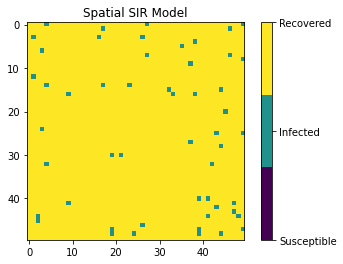

In [9]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#Parameters
grid_size = 50
beta = 0.3     # infection probability per neighbor
gamma = 0.05   # recovery probability per time step
days = 100

# 0 = Susceptible, 1 = Infected, 2 = Recovered
grid = np.zeros((grid_size, grid_size), dtype=int)

# Initial infected
mid = grid_size // 2
grid[mid, mid] = 1

# set up for the animation
fig, ax = plt.subplots()
cmap = plt.get_cmap('viridis', 3)  # 3 discrete colors
im = ax.imshow(grid, cmap=cmap, vmin=0, vmax=2)
ax.set_title('Spatial SIR Model')

# colorbar as a legend
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['Susceptible', 'Infected', 'Recovered'])

def count_infected_neighbors(x, y, grid):
    #Count how many neighbors are infected
    count = 0
    for i in range(max(0, x-1), min(grid_size, x+2)):
        for j in range(max(0, y-1), min(grid_size, y+2)):
            if (i, j) != (x, y) and grid[i, j] == 1:
                count += 1
    return count

def update(frame):
    global grid
    new_grid = grid.copy()
    
    for i in range(grid_size):
        for j in range(grid_size):
            if grid[i, j] == 0:  # susceptible
                infected_neighbors = count_infected_neighbors(i, j, grid)
                if infected_neighbors > 0:
                    if np.random.rand() < 1 - (1 - beta)**infected_neighbors:
                        new_grid[i, j] = 1
            elif grid[i, j] == 1:  # infected
                if np.random.rand() < gamma:
                    new_grid[i, j] = 2  # recover

    grid = new_grid
    im.set_data(grid)
    return [im]

ani = FuncAnimation(fig, update, frames=days, interval=200, blit=True)
HTML(ani.to_jshtml())

### 2.2 Spatial SIR, 2 starting points

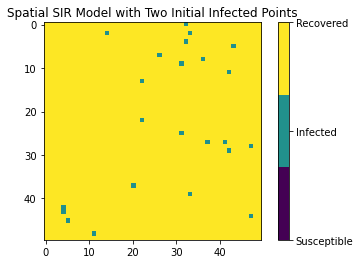

In [15]:
from matplotlib.animation import FuncAnimation, PillowWriter
#same as above, modified for 2 initial positions on grid
#parameters
grid_size = 50
beta = 0.45
gamma = 0.05
days = 100

# 0 = Susceptible, 1 = Infected, 2 = Recovered
grid = np.zeros((grid_size, grid_size), dtype=int)

# Initial infected points
initial_infected = [(grid_size//3, grid_size//3), (2*grid_size//3, 2*grid_size//3)] #2 starting points
for x, y in initial_infected:
    grid[x, y] = 1

fig, ax = plt.subplots()
cmap = plt.get_cmap('viridis', 3)
im = ax.imshow(grid, cmap=cmap, vmin=0, vmax=2)
ax.set_title('Spatial SIR Model with Two Initial Infected Points')

# Colorbar as legend
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['Susceptible', 'Infected', 'Recovered'])

def count_infected_neighbors(x, y, grid):
    count = 0
    for i in range(max(0, x-1), min(grid_size, x+2)):
        for j in range(max(0, y-1), min(grid_size, y+2)):
            if (i, j) != (x, y) and grid[i, j] == 1:
                count += 1
    return count

def update(frame):
    global grid
    new_grid = grid.copy()
    
    for i in range(grid_size):
        for j in range(grid_size):
            if grid[i, j] == 0:  # susceptible
                infected_neighbors = count_infected_neighbors(i, j, grid)
                if infected_neighbors > 0:
                    if np.random.rand() < 1 - (1 - beta)**infected_neighbors:
                        new_grid[i, j] = 1
            elif grid[i, j] == 1:  # infected
                if np.random.rand() < gamma:
                    new_grid[i, j] = 2  # recover

    grid = new_grid
    im.set_data(grid)
    return [im]

# Save animation as GIF
#ani.save("animation.gif", writer=PillowWriter(fps=100))
ani = FuncAnimation(fig, update, frames=days, interval=200, blit=True)
HTML(ani.to_jshtml())

### 2.3 SIRVD model: effect of vaccination

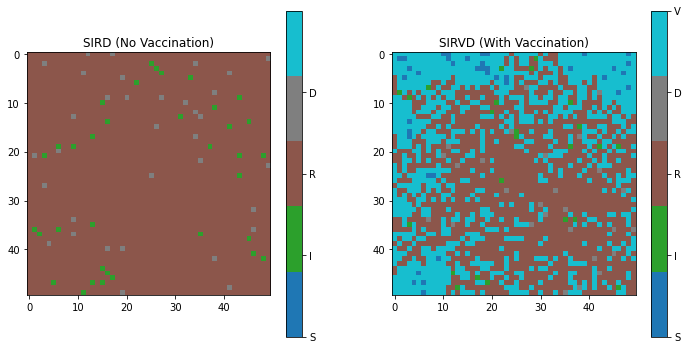

In [17]:
# parameters
grid_size = 50
beta = 0.3        # infection probability per infected neighbor
gamma = 0.05      # recovery parameter
mu = 0.01         # death probability
vaccine_rate = 0.02  # for SIRVD
days = 100

initial_infected = [(25,25), (35,35)]#starting points on grid

#Function to initialize grid 
def init_grid(vaccination=False):
    # 0=S, 1=I, 2=R, 3=D, 4=V (V only if vaccination=True)
    grid = np.zeros((grid_size, grid_size), dtype=int)
    for x, y in initial_infected:
        grid[x, y] = 1
    return grid

#Count infected neighbors
def infected_neighbors(x, y, grid):
    count = 0
    for i in range(max(0, x-1), min(grid_size, x+2)):
        for j in range(max(0, y-1), min(grid_size, y+2)):
            if (i,j)!=(x,y) and grid[i,j]==1:
                count +=1
    return count

# update function, now including vaccination and dead
def update_grid(grid, vaccination=False):
    new_grid = grid.copy()
    for i in range(grid_size):
        for j in range(grid_size):
            if grid[i,j]==0:  # Susceptible
                if vaccination and np.random.rand() < vaccine_rate:
                    new_grid[i,j] = 4  # Vaccinated
                else:
                    if infected_neighbors(i,j,grid) > 0:
                        if np.random.rand() < 1 - (1-beta)**infected_neighbors(i,j,grid):
                            new_grid[i,j] = 1
            elif grid[i,j]==1:  # Infected
                if np.random.rand() < mu:
                    new_grid[i,j] = 3  # Dead
                elif np.random.rand() < gamma:
                    new_grid[i,j] = 2  # Recovered
    return new_grid

#Initialize grids
grid_sird = init_grid(vaccination=False)
grid_sirvd = init_grid(vaccination=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
cmap = plt.get_cmap('tab10', 5)

im1 = ax1.imshow(grid_sird, cmap=cmap, vmin=0, vmax=4)
ax1.set_title('SIRD (No Vaccination)')
cbar1 = plt.colorbar(im1, ax=ax1, ticks=[0,1,2,3])
cbar1.ax.set_yticklabels(['S','I','R','D'])

im2 = ax2.imshow(grid_sirvd, cmap=cmap, vmin=0, vmax=4)
ax2.set_title('SIRVD (With Vaccination)')
cbar2 = plt.colorbar(im2, ax=ax2, ticks=[0,1,2,3,4])
cbar2.ax.set_yticklabels(['S','I','R','D','V'])

def update(frame):
    global grid_sird, grid_sirvd
    grid_sird = update_grid(grid_sird, vaccination=False)
    grid_sirvd = update_grid(grid_sirvd, vaccination=True)
    im1.set_data(grid_sird)
    im2.set_data(grid_sirvd)
    return [im1, im2]

ani = FuncAnimation(fig, update, frames=days, interval=200, blit=True)
HTML(ani.to_jshtml())

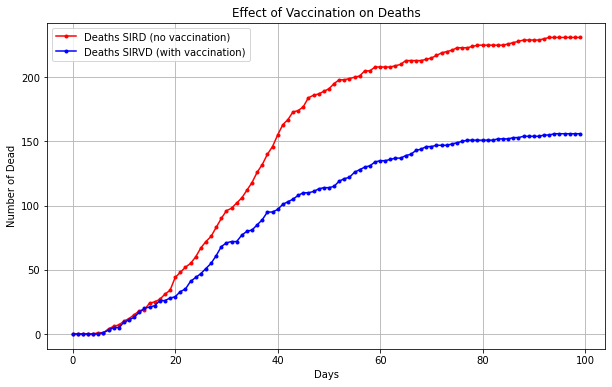

In [24]:
def run_sird_sim(grid_size=50, beta=0.3, gamma=0.05, mu=0.005, days=100, initial_infected=[(25,25)], vaccine_rate=0.0):
    # 0=S, 1=I, 2=R, 3=D, 4=V
    grid = np.zeros((grid_size, grid_size), dtype=int)
    for x, y in initial_infected:
        grid[x, y] = 1

    counts = {'S':[], 'I':[], 'R':[], 'D':[], 'V':[]}

    def infected_neighbors(x, y):
        count = 0
        for i in range(max(0, x-1), min(grid_size, x+2)):
            for j in range(max(0, y-1), min(grid_size, y+2)):
                if (i,j)!=(x,y) and grid[i,j]==1:
                    count +=1
        return count

    for _ in range(days):
        new_grid = grid.copy()
        for i in range(grid_size):
            for j in range(grid_size):
                if grid[i,j]==0:  # S
                    if np.random.rand() < vaccine_rate:
                        new_grid[i,j] = 4
                    else:
                        if infected_neighbors(i,j) > 0:
                            if np.random.rand() < 1 - (1-beta)**infected_neighbors(i,j):
                                new_grid[i,j] = 1
                elif grid[i,j]==1:  # I
                    if np.random.rand() < mu:
                        new_grid[i,j] = 3
                    elif np.random.rand() < gamma:
                        new_grid[i,j] = 2
        grid = new_grid
        # count
        counts['S'].append(np.sum(grid==0))
        counts['I'].append(np.sum(grid==1))
        counts['R'].append(np.sum(grid==2))
        counts['D'].append(np.sum(grid==3))
        counts['V'].append(np.sum(grid==4))
    return counts

days = 100
initial_infected = [(25,25), (35,35)] #starting points of infected (2 points)
sird_counts = run_sird_sim(days=days, initial_infected=initial_infected, vaccine_rate=0.0)
sirvd_counts = run_sird_sim(days=days, initial_infected=initial_infected, vaccine_rate=0.02)

plt.figure(figsize=(10,6))
plt.plot(sird_counts['D'], 'r-o', label='Deaths SIRD (no vaccination)',markersize=3)     
plt.plot(sirvd_counts['D'], 'b-o', label='Deaths SIRVD (with vaccination)',markersize=3) 
plt.xlabel('Days')
plt.ylabel('Number of Dead')
plt.title('Effect of Vaccination on Deaths')
plt.grid(True)
plt.legend()
plt.show()